In [32]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [33]:
# Data load prepare
dataset = pd.read_csv('smoking_driking_dataset_Ver01.csv')
dataset['sex'] = dataset['sex'].replace('Male', 0.0)
dataset['sex'] = dataset['sex'].replace('Female', 1.0)
# dataset['SMK_stat_type_cd'] = dataset['SMK_stat_type_cd'].apply(lambda x: x-1)

In [34]:
# Remove non smokers that used to smoke before from dataset
dataset = dataset[dataset['SMK_stat_type_cd'] != 2]

In [35]:
# Convert labels to floats
dataset['SMK_stat_type_cd'] = dataset['SMK_stat_type_cd'].apply(lambda x: 1.0 if x == 3.0 else 0.0)
# dataset['DRK_YN'] = dataset['DRK_YN'].apply(lambda x: 1.0 if x == 'Y' else 0.0)

In [36]:
# Remove some input features from dataset
dataset = dataset.drop(['waistline','sight_left','sight_right','hear_left','hear_right','urine_protein','DRK_YN'], axis=1)

### Test drop features from dataset

In [37]:
# dataset = dataset.drop(['sex'], axis=1)

## Continue to training

In [38]:
# Construct pandas dataframes for X and y values
df_X = dataset.drop(['SMK_stat_type_cd'], axis=1)
df_y = pd.DataFrame(dataset['SMK_stat_type_cd'])

In [39]:
corr = dataset.corr()

<Axes: >

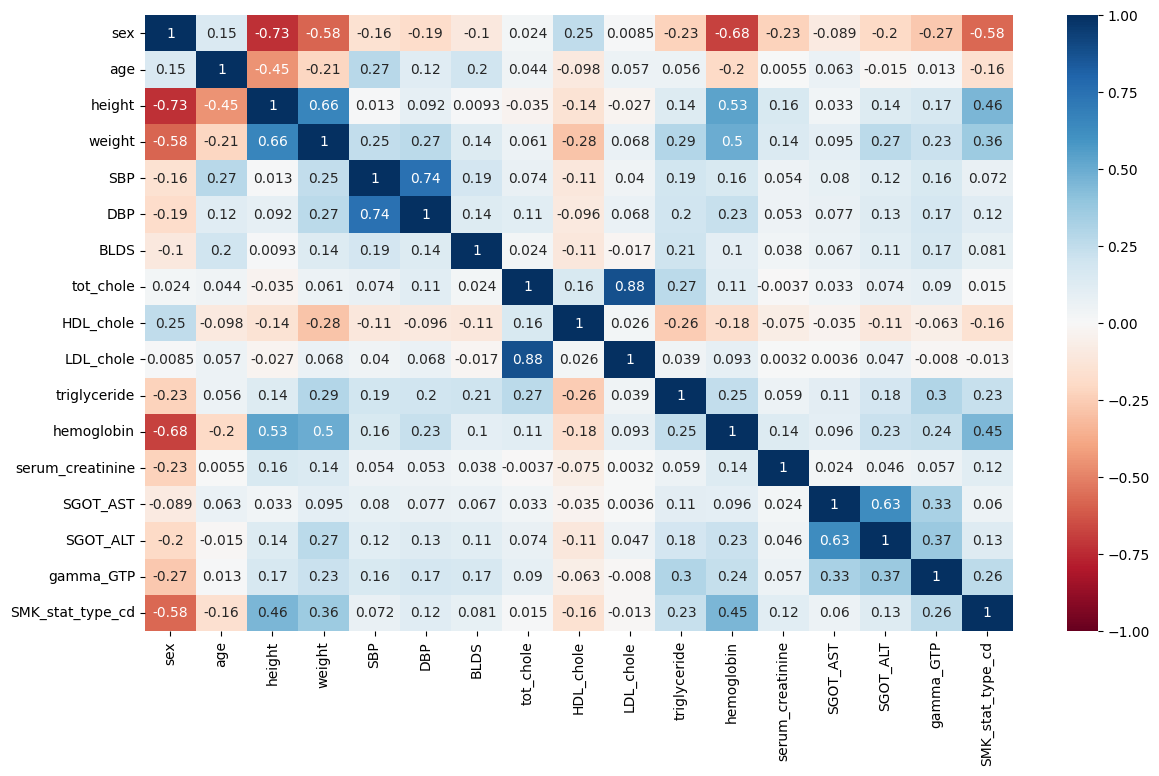

In [40]:
# Show variable correlation relations with respect to 'SMK_stat_type_cd'
plt.figure(figsize=(14, 8))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize':10})
# More heatmap arguments
# square=True will make the squares well.. squares

In [41]:
# Convert dataframes to numpy arrays (not sure if needed)
X = df_X.astype('float32').values
y = df_y.astype('float32').values

In [42]:
# Train Test Split, Set X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Conver y labels to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

#Normalize inputs
# X_train = torch.nn.functional.normalize(X_train)
# X_test = torch.nn.functional.normalize(X_test)

In [43]:
print(f'Training vs testing size: {X_train.shape} / {X_test.shape}')

Training vs testing size: torch.Size([653116, 16]) / torch.Size([163279, 16])


In [44]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [45]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.
    """
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    # return total_time

In [46]:
class SmokersBinaryClassification(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_layers, hidden_features):
        super().__init__()  
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.ReLU()        
        )
        for i in range(hidden_layers):
            self.linear_layer_stack.add_module(f'{i*2+2}', nn.Linear(in_features=hidden_features, out_features=hidden_features))
            self.linear_layer_stack.add_module(f'{i*2+3}', nn.ReLU())
        
        self.linear_layer_stack.add_module(f'{hidden_layers*2+2}', nn.Linear(in_features=hidden_features, out_features=output_features))
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [47]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [48]:
model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_layers=1, hidden_features=16).to(device) # 5000 epochs 78.5
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_features=32) # 5000 epochs 79.10
# model = SmokersBinaryClassification2(input_features=16, output_features=1, hidden_layers=2, hidden_features=8) # 5000 epochs 78.98
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_layers=2, hidden_features=4) # 5000 epochs 78.98
# model = SmokersBinaryClassification(input_features=15, output_features=1, hidden_layers=1, hidden_features=15) # 5000, 79.24
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_layers=3, hidden_features=16)
model

SmokersBinaryClassification(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [49]:
# Set the criterion of the model to measure the error
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [52]:
# Train model
# Random seeds
torch.manual_seed(42)

# Loop through data
epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

start_time = timer()
for epoch in tqdm(range(epochs)):
    model.train()

    # 1. Forward passs
    y_train_logits = model(X_train)
    y_train_pred = torch.round(torch.sigmoid(y_train_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_train_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, y_pred=y_train_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 50 == 0:
        print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


end_time = timer()
print_train_time(start=start_time, end=end_time, device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0000 | Loss: 0.4557, Acc: 78.18% | Test Loss: 0.4541, Test Acc: 78.10%
Epoch: 0050 | Loss: 0.4550, Acc: 78.20% | Test Loss: 0.4534, Test Acc: 78.13%
Train time on cuda: 1.584 seconds


1.5840257849995396

In [40]:
with torch.inference_mode():
    y_test_logits = model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
print(f'Test accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test accuracy: 79.36%


In [39]:
# Save model
from pathlib import Path

MODEL_PATH = Path('saved_models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = 'in-16-out-79p36-10000epoch.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

def save_model():  
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

# save_model()

In [35]:
# Load in a saved state_dicti we have to instantiate a new instance of our model class
loaded_model = SmokersBinaryClassification()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [41]:
my_vitals = torch.tensor([0.0, 40, 170, 79, 118, 75, 91, 174, 40, 100, 134, 15.3, 0.8, 27.1, 26.0, 38], dtype=torch.float32)
my_vitals

tensor([  0.0000,  40.0000, 170.0000,  79.0000, 118.0000,  75.0000,  91.0000,
        174.0000,  40.0000, 100.0000, 134.0000,  15.3000,   0.8000,  27.1000,
         26.0000,  38.0000])

In [43]:
# Single prediction output
with torch.inference_mode():
    y_test_logits = model(my_vitals)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
if y_test_pred == 1: 
    print(f'Is smoker with sigmoid output {torch.sigmoid(y_test_logits).item():.5f}')
else:
    print(f'Is not smoker with sigmoid output {torch.sigmoid(y_test_logits).item():.5f}')

Is smoker with sigmoid output 0.62984
